## Design Project

In [1]:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import uniform
from sklearn.svm import SVR, NuSVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

/opt/mambaforge/envs/designproject_2023/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = pd.DataFrame()    # initialise results dataframe

def hyperparameter_search_EN(dataloader, param_grid, results, clock_name='EN', cores=20):
    # Unpack dataloader
    x_train = dataloader['x_train']
    y_train = dataloader['y_train']
    x_test = dataloader['x_test']
    y_test = dataloader['y_test']

    # Create Elastic Net regression model
    elastic_net = ElasticNet()

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=cores)
    grid_search.fit(x_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Use the best model for prediction
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(x_train)
    y_pred_test = best_model.predict(x_test)

    # Evaluate the model
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print("Mean Squared Error (Train):", mse_train)
    print("Mean Squared Error (Test):", mse_test)
    print("R-squared (Train):", r2_train)
    print("R-squared (Test):", r2_test)

    # Append results to results dataframe
    output = ({
        'model': clock_name,
        'hyperparameters': [best_params],
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test
    })

    results = pd.concat([results, pd.DataFrame(output)], ignore_index=True)

    return results, best_model, y_pred_test

In [3]:
def standardise(Dataframe):
    # standardises all the columns of a Dataframe
    standardised = (Dataframe - Dataframe.mean())/Dataframe.std()
    standardised =  standardised.fillna(0)
    return(standardised)

def validation_plot(y_val, y_pred):
    r2 = r2_score(y_val, y_pred)
    diff = np.round(np.mean(np.abs(y_pred-y_val)),2)
    # sort data because it's easier to interpret
    zipped = zip(y_pred, y_val)
    sorted_zipped = sorted(zipped, key=lambda x: x[1])
    y_pred, y_val = zip(*sorted_zipped)
    # plot
    x = range(0,np.size(y_pred))
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title(f'R-squared: {r2}\nMean Absolute Difference: {diff}')
    ax.set_xlabel('participant');
    ax.set_ylabel('age');
    ax.scatter(x, y_val);
    ax.scatter(x, y_pred, color='orange');
    ax.legend(['Observation', 'Predicted']);

def correlation_list(predictor, response):
    colnames = predictor.columns
    p_vec = []

    for i in range(len(colnames)):
        pearson_corr = np.corrcoef(response, predictor.iloc[:, i])[0, 1]
        p_vec.append(pearson_corr)

    df = pd.DataFrame({'Pearson Correlation':p_vec, 'SeqIndex':colnames})
    df = df.iloc[np.abs(df['Pearson Correlation']).argsort()[::-1]]

    return df.merge(analyte_conv)

def search_metadata(metadata, search_term):
    # metadata = R2_Meta
    # search_term = r'R1|R2'

    # Perform search
    matches = [col for col in metadata.columns if re.search(search_term, col, re.IGNORECASE)]

    matching = metadata[matches]

    # Print results
    print(f'Found {len(matches)} matches')
    print('Match   |   contains nan values')
    print(metadata[matches].isna().sum())

    out = matching.head(3).T
    # set column names
    out.columns = ['Sample 1', 'Sample 2', 'Sample 3']
    return out

def evaluate_model(y_train_true, y_train_pred, y_test_true, y_test_pred):
    mse_train = mean_squared_error(y_train_true, y_train_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    r2_train = r2_score(y_train_true, y_train_pred)
    r2_test = r2_score(y_test_true, y_test_pred)

    print("Mean Squared Error (Train):", mse_train)
    print("Mean Squared Error (Test):", mse_test)
    print("R-squared (Train):", r2_train)
    print("R-squared (Test):", r2_test)

def minmax_scale(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    if isinstance(df, pd.DataFrame):
        scaled_data = pd.DataFrame(scaled_data, columns=df.columns)

    return scaled_data

## Reading in data

Your working directory should look like this:

```
.
├── data
│   ├── norm_meta_batch_effect_removal_phase1.csv
│   ├── norm_meta_batch_effect_removal_phase2.csv
│   ├── norm_meta_batch_effect_removed_scaled_logtrans_phase1.csv
│   ├── norm_meta_batch_effect_removed_scaled_logtrans_phase2.csv
│   ├── norm_meta_phase1.csv
│   ├── norm_meta_phase2.csv
│   └── probe_metadata.csv
└── Design_Project.ipynb
```

In [4]:
# Choose dataset
dataset = 'norm_meta_batch_effect_removal'  # best UMAP results
# dataset = 'norm_meta'
# dataset = 'norm_meta_batch_effect_removed_scaled_logtrans'


In [5]:
R1_path = 'data/'+dataset+'_phase1.csv'
R2_path = 'data/'+dataset+'_phase2.csv'
probe_path = 'data/probe_metadata.csv'

# Round 1
R1_SOMAMeta_raw = pd.read_csv(R1_path, low_memory=False)
R1_SOMAMeta_raw['VisitB_Date'] = pd.to_datetime(R1_SOMAMeta_raw['VisitB_Date'])
R1_SOMAMeta_raw['year-month'] = R1_SOMAMeta_raw['VisitB_Date'].dt.strftime('%Y-%m')

# Remove batch effected months April, May, June, July (2003)
months_to_remove = [4, 5, 6, 7] 
R1_SOMAMeta = R1_SOMAMeta_raw.copy()
R1_SOMAMeta = R1_SOMAMeta[~((R1_SOMAMeta['VisitB_Date'].dt.year == 2003) & 
                            (R1_SOMAMeta['VisitB_Date'].dt.month.isin(months_to_remove)))]
R1_SOMAMeta['year-month'] = R1_SOMAMeta['VisitB_Date'].dt.strftime('%Y-%m')


# Round 2
R2_SOMAMeta = pd.read_csv(R2_path, low_memory=False)

R2_SOMAMeta['Examination date R2'] = pd.to_datetime(R2_SOMAMeta['Examination date R2'])
R2_SOMAMeta['year-month'] = R2_SOMAMeta['Examination date R2'].dt.strftime('%Y-%m')


# Select proteins
R1_SOMA = R1_SOMAMeta.loc[:, R1_SOMAMeta.columns.str.startswith('seq')]
R2_SOMA = R2_SOMAMeta.loc[:, R2_SOMAMeta.columns.str.startswith('seq')]

 # there is one protein in R2 that is not in R1 (seq.20367.6)
shared_proteins = list(set(R1_SOMA.columns) & set(R2_SOMA.columns)) 
R1_SOMA = R1_SOMA.loc[:, shared_proteins]
R2_SOMA = R2_SOMA.loc[:, shared_proteins]


# Select metadata
R1_Meta = R1_SOMAMeta.loc[:, ~R1_SOMAMeta.columns.str.startswith('seq')]
R2_Meta = R2_SOMAMeta.loc[:, ~R2_SOMAMeta.columns.str.startswith('seq')]


# TargetID to EntrezID
analyte = pd.read_csv(probe_path)
analyte_conv = analyte[['SeqIndex', 'EntrezGeneSymbol']]

## Average Round 1 and Round 2

In [6]:
# Age (y-data)
R1_AgeID = R1_SOMAMeta[['visit_id', 'Age_years', 'Gender']]
R2_AgeID = R2_SOMAMeta[['visit_id', 'Age R2 (year)']]

# match R1 and R2 and rename
R1R2_AgeID = R1_AgeID.merge(R2_AgeID, on='visit_id').rename(columns={'Age_years': 'Age_R1', 'Age R2 (year)': 'Age_R2', 'Gender': 'Gender'})
R1R2_AgeID['Gender'] = R1R2_AgeID['Gender'].replace({"M": 0, "F": 1})

# calculate average
age_avg = (R1R2_AgeID['Age_R2'] + R1R2_AgeID['Age_R1']) / 2

# Protein (x-data)
shared_proteins = list(set(R1_SOMA.columns) & set(R2_SOMA.columns))
sel_col = ['visit_id'] + shared_proteins

R1_SOMAID = R1_SOMAMeta[sel_col]
R2_SOMAID = R2_SOMAMeta[sel_col]

# merge so the visit_ids match
R1R2_SOMAID = R1_SOMAID.merge(R2_SOMAID, on='visit_id')

avg_values = []

for protein in shared_proteins:
    col1 = R1R2_SOMAID[f'{protein}_x']
    col2 = R1R2_SOMAID[f'{protein}_y']
    avg_values.append((col2.values + col1.values)/2)

SOMA_avg = pd.DataFrame(np.array(avg_values).T, columns=shared_proteins)


/tmp/ipykernel_3390037/3523641363.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  R1R2_AgeID['Gender'] = R1R2_AgeID['Gender'].replace({"M": 0, "F": 1})


In [7]:
# Split train/test-data
X = SOMA_avg
y = age_avg
stratify = None

x_train_avg, x_test_avg, y_train_avg, y_test_avg = train_test_split(
    X, 
    y, 
    test_size = 0.2, 
    random_state = 42,
    stratify = stratify
)


sc = MinMaxScaler()
x_train_avg = sc.fit_transform(x_train_avg)
x_test_avg = sc.transform(x_test_avg)

#### Elastic Net

In [8]:
%%script echo skip tuning
# Hyperparameter tuning
params = {
    'alpha':[0.007, 0.008, 0.009],  
    'l1_ratio': [0.6,0.7, 0.8, 0.9],
    'max_iter':[15000]
}
print('elnet start')
elnet_avg = GridSearchCV(ElasticNet(), params, n_jobs=35, scoring='neg_mean_squared_error', cv=5).fit(x_train_avg, y_train_avg)
print('elnet end')
print(elnet_avg.best_params_)

skip tuning


R-squared on traindata: 0.8443949963269599
R-squared on testdata: 0.6756014454666996


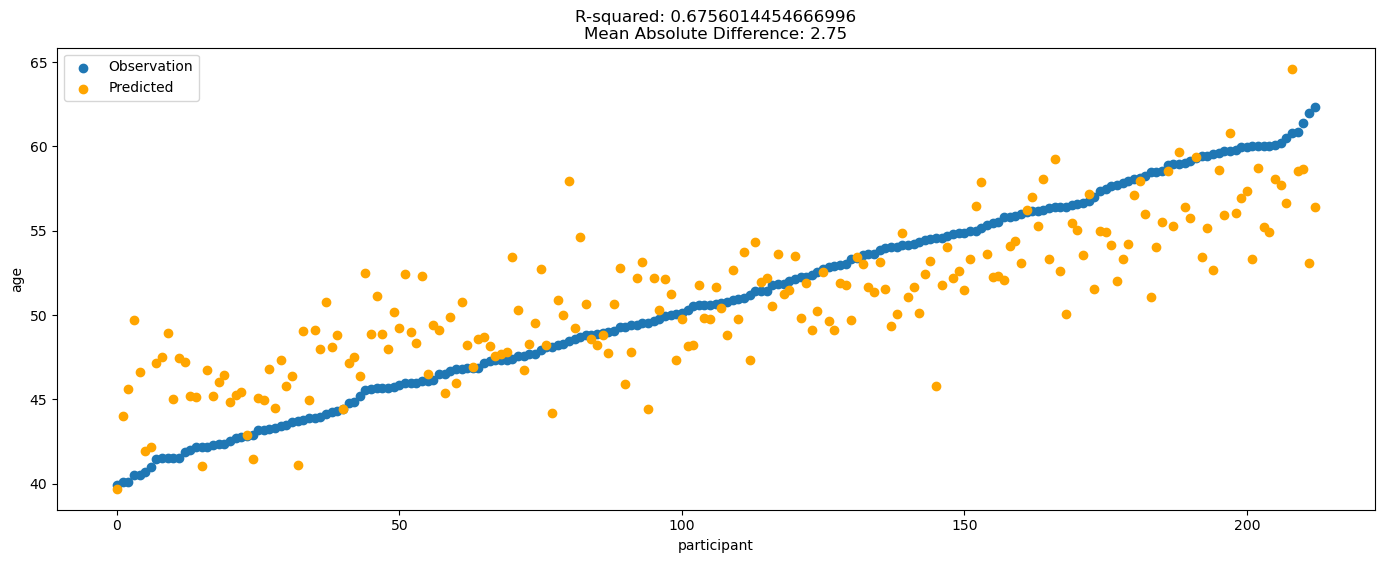

In [9]:
# Model using found hyperparameters
params = {'alpha': 0.015, 'l1_ratio': 0.7, 'max_iter': 15000}
model = ElasticNet(**params).fit(x_train_avg, y_train_avg)


# Apply the model
y_pred = model.predict(x_test_avg)
r2_train = r2_score(y_train_avg, model.predict(x_train_avg))
r2_test = r2_score(y_test_avg, y_pred)

print('R-squared on traindata:', r2_train)
print('R-squared on testdata:', r2_test)
validation_plot(y_test_avg, y_pred)

#### Store the errors on the test data

In [10]:
test_ages = pd.DataFrame(age_avg.iloc[y_test_avg.index])
test_corr_data = pd.concat([test_ages.reset_index(drop=True), pd.DataFrame(y_pred).reset_index(drop=True)],
                       axis = 1, ignore_index=True)
test_corr_data.columns = ['Average age', 'Predicted average age']
test_corr_data['Error'] = test_corr_data['Predicted average age'] - test_corr_data['Average age']
print(np.mean(abs(test_corr_data['Error'])))

2.754513700502824


#### Plot the errors in function of the true average age

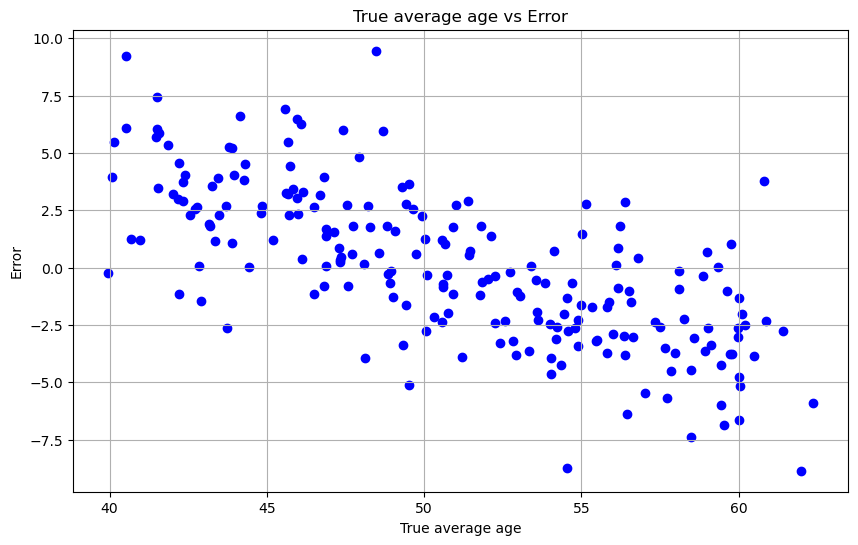

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(test_corr_data['Average age'], test_corr_data['Error'], color='blue')

plt.title('True average age vs Error')
plt.xlabel('True average age')
plt.ylabel('Error')
plt.grid(True)
plt.show()

#### Fit a lowess on the average ages vs the predicted average ages and calculate age gaps (=difference between predicted value and lowess smoother)

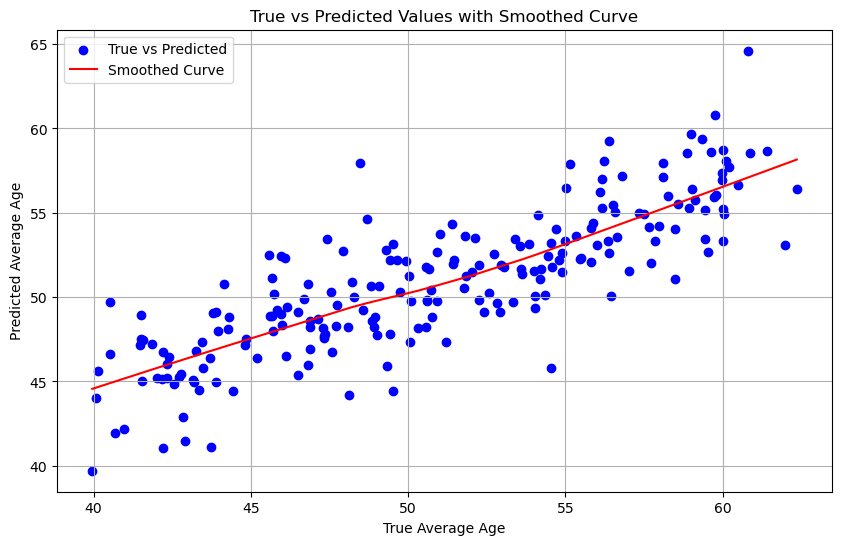

In [12]:
import statsmodels.api as sm

# Fit a local regression (LOESS)
lowess = sm.nonparametric.lowess
frac = 2/3  # Fraction parameter set to 2/3

# Sorting data by chronological age for smoother plot
test_corr_data_sorted = test_corr_data.sort_values(by='Average age')

# Fit the lowess model
predicted_smooth = lowess(test_corr_data_sorted['Predicted average age'], 
                          test_corr_data_sorted['Average age'], 
                          frac=frac)

# Extracting smoothed values
smoothed_values = predicted_smooth[:, 1]

# Plotting true vs predicted values with smoothed curve and ElasticNet predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_corr_data['Average age'], test_corr_data['Predicted average age'], color='blue', label='True vs Predicted')
plt.plot(test_corr_data_sorted['Average age'], smoothed_values, color='red', label='Smoothed Curve')

plt.title('True vs Predicted Values with Smoothed Curve')
plt.xlabel('True Average Age')
plt.ylabel('Predicted Average Age')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
individual_age_gaps = test_corr_data_sorted['Predicted average age'] - smoothed_values

# Reindex individual_age_gaps to match the original index of test_corr_data
individual_age_gaps = individual_age_gaps.reindex(test_corr_data.index)

# Add individual age gaps to the DataFrame
test_corr_data['Individual age gaps'] = individual_age_gaps

# Print the DataFrame to verify
test_corr_data.head()

,Average age,Predicted average age,Error,Individual age gaps
0,60.096370,58.082207,-2.014162,1.475518
1,46.871301,48.234146,1.362845,-0.407882
2,56.626644,53.588092,-3.038552,-0.661074
3,60.011849,58.695771,-1.316079,2.146948
4,42.568630,44.859685,2.291055,-1.273099


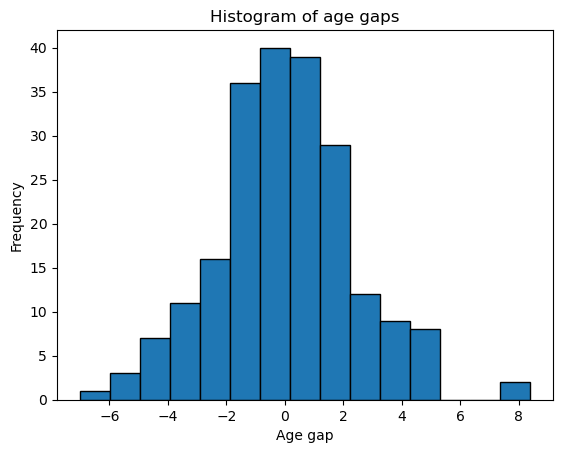

In [14]:
#histogram of age gaps
plt.hist(test_corr_data['Individual age gaps'], bins=15, edgecolor='black')
plt.title('Histogram of age gaps')
plt.xlabel('Age gap')
plt.ylabel('Frequency')
plt.show()

#### Concatenate round 1 and round 2 metadata to do correlation analysis

In [15]:
R1_Metadata = R1_Meta
R1_Metadata.columns = [col + '_R1'if col != 'visit_id' else col for col in R1_Metadata.columns]
R2_Metadata = R2_Meta
R2_Metadata.columns = [col + '_R2'if col != 'visit_id' else col for col in R2_Metadata.columns]

In [16]:
all_metadata = pd.merge(R1_Metadata, R2_Metadata, on='visit_id')
print(all_metadata.shape)

(1064, 1677)


In [17]:
all(R1R2_AgeID['visit_id'] == all_metadata['visit_id'])

True

#### Correlation analysis of delta risk variables with age gaps

In [18]:
tmp_metadata = all_metadata.iloc[y_test_avg.index].reset_index()
metadata_delta = pd.DataFrame()
metadata_delta['Carotid IMT delta'] = tmp_metadata['Carotid IMT delta_R2']
metadata_delta['Femoral IMT delta'] = tmp_metadata['Femoral IMT delta_R2']
metadata_delta['BMI delta (kg/m²)'] = tmp_metadata['BMI delta (kg/m2)_R2']
metadata_delta['Systolic BP delta (mmHg)'] = tmp_metadata['Systolic BP delta (mmHg)_R2']
metadata_delta['Diastolic BP delta (mmHg)'] = tmp_metadata['Diastolic BP delta (mmHg)_R2']
metadata_delta['Pulse Pressure delta (mmHg)'] = tmp_metadata['Pulse Pressure delta (mmHg)_R2']
metadata_delta['Total cholesterol delta'] = tmp_metadata['Total cholesterol delta_R2']
metadata_delta['HDL cholesterol delta'] = tmp_metadata['HDL cholesterol delta_R2']
metadata_delta['LDL cholesterol delta'] = tmp_metadata['LDL cholesterol delta_R2']
metadata_delta['Triglycerides delta (mg/dl)'] = tmp_metadata['Triglycerides (mg/dl; R2)_R2'] - tmp_metadata['Triglycerides (mg/dl; R1)_R2']
metadata_delta['High sensitive CRP delta (mg/dL)'] = tmp_metadata['High sensitive CRP delta (mg/dL)_R2']
metadata_delta['IL6 delta'] = tmp_metadata['IL6 R2_R2'] - tmp_metadata['IL6 R1_R2']
metadata_delta['White blood cells delta'] = tmp_metadata['WBC R2_R2'] - tmp_metadata['Whitebloodcellcount10e3microl_R1']
metadata_delta['Fibrinogen delta'] = tmp_metadata['Fibrinogen R2_R2'] - tmp_metadata['Fibrinogen R1_R2']
metadata_delta['Homocystein delta'] = tmp_metadata['Homocystein R2_R2'] - tmp_metadata['Homocystein R1_R2']
metadata_delta['Glycemia delta'] = tmp_metadata['Glycemia delta_R2']
metadata_delta['Creatinin delta (mg/dl)'] = tmp_metadata['creat R2_R2'] - tmp_metadata['Creatinin_mgdl_R1']
metadata_delta['Uric acid delta (mg/dL)'] = tmp_metadata['Uric acid delta (mg/dL)_R2']
metadata_delta['Pack years nicotine delta (year)'] = tmp_metadata['Pack years nicotine delta (year)_R2']

In [19]:
from scipy.stats import pearsonr
from statsmodels.stats import multitest

colnames_new = []
p_vec = []
pval_vec = []
errors = test_corr_data['Individual age gaps']
errors.reset_index(drop=True, inplace=True)
test_metadata = metadata_delta

for i in np.arange(0, len(test_metadata.columns)):
    predictor = test_metadata.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    errors_filtered = errors[non_nan_idx]

    if len(errors_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(errors_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(test_metadata.columns[i])


corr_result = pd.DataFrame({'Predictor':colnames_new, 'Pearson Correlation':p_vec, 'P-value': pval_vec})
corr_result = corr_result.iloc[np.abs(corr_result['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

reject, corrected_pvals, _, _ = multitest.multipletests(corr_result['P-value'], method='fdr_bh')
corr_result['Corrected P-value'] = corrected_pvals
corr_result['Reject Null Hypothesis'] = reject

corr_result = corr_result.iloc[corr_result['Corrected P-value'].argsort()].reset_index(drop=True)

significant = corr_result[(corr_result['Reject Null Hypothesis'] == True)]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)
# significant.reset_index(drop=True)
corr_result

,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,Glycemia delta,0.174850,0.010571,0.093533,False
1,High sensitive CRP delta (mg/dL),-0.174404,0.010963,0.093533,False
2,Total cholesterol delta,-0.166859,0.014768,0.093533,False
3,LDL cholesterol delta,-0.153144,0.027975,0.132883,False
4,Diastolic BP delta (mmHg),-0.114533,0.095474,0.324412,False
5,Systolic BP delta (mmHg),-0.106337,0.121815,0.324412,False
6,BMI delta (kg/m²),-0.103878,0.130733,0.324412,False
7,Triglycerides delta (mg/dl),-0.102331,0.136595,0.324412,False
8,Fibrinogen delta,-0.097230,0.157355,0.332195,False
9,Uric acid delta (mg/dL),-0.065065,0.344659,0.595319,False


#### Correlation analysis of average risk variables with age gaps

In [20]:
tmp_metadata = all_metadata.iloc[y_test_avg.index].reset_index()
metadata_average = pd.DataFrame()
metadata_average['Carotid IMT average'] = (tmp_metadata['Carotid IMT R2_R2'] + tmp_metadata['Carotid IMT R1_R2'])/2
metadata_average['Femoral IMT average'] = (tmp_metadata['Femoral IMT R2_R2'] + tmp_metadata['Femoral IMT R1_R2'])/2
metadata_average['BMI averaged (kg/m2)'] = tmp_metadata['BMI averaged (kg/m2)_R2']
metadata_average['Systolic BP average (mmHg)'] = tmp_metadata['Systolic BP averaged (mmHg)_R2']
metadata_average['Diastolic BP average (mmHg)'] = tmp_metadata['Diastolic BP averaged (mmHg)_R2']
metadata_average['Pulse Pressure average (mmHg)'] = tmp_metadata['Pulse pressure averaged (mmHg)_R2']
metadata_average['Total cholesterol average'] = tmp_metadata['Total cholesterol averaged_R2']
metadata_average['HDL cholesterol average'] = tmp_metadata['HDL cholesterol averaged_R2']
metadata_average['LDL cholesterol average'] = tmp_metadata['LDL cholesterol averaged_R2']
metadata_average['Triglycerides average (mg/dl)'] = (tmp_metadata['Triglycerides (mg/dl; R2)_R2'] + tmp_metadata['Triglycerides (mg/dl; R1)_R2'])/2
metadata_average['High sensitive CRP average (mg/dL)'] = tmp_metadata['High sensitive CRP averaged (mg/dL)_R2']
metadata_average['IL6 average'] = (tmp_metadata['IL6 R2_R2'] + tmp_metadata['IL6 R1_R2'])/2
metadata_average['White blood cells average'] = (tmp_metadata['WBC R2_R2'] + tmp_metadata['Whitebloodcellcount10e3microl_R1'])/2
metadata_average['Fibrinogen average'] = (tmp_metadata['Fibrinogen R2_R2'] + tmp_metadata['Fibrinogen R1_R2'])/2
metadata_average['Homocystein average'] = (tmp_metadata['Homocystein R2_R2'] + tmp_metadata['Homocystein R1_R2'])/2
metadata_average['Glycemia average'] = tmp_metadata['Glycemia averaged_R2']
metadata_average['Creatinin average (mg/dl)'] = (tmp_metadata['creat R2_R2'] + tmp_metadata['Creatinin_mgdl_R1'])/2
metadata_average['Uric acid average (mg/dL)'] = tmp_metadata['Uric acid averaged (mg/dL)_R2']
metadata_average['Pack years nicotine average (year)'] = (tmp_metadata['Pack years nicotine R1 (year)_R2'] + tmp_metadata['Pack years nicotine R2 (year)_R2'])/2

In [21]:
from scipy.stats import pearsonr
from statsmodels.stats import multitest

colnames_new = []
p_vec = []
pval_vec = []
errors = test_corr_data['Individual age gaps']
errors.reset_index(drop=True, inplace=True)
test_metadata = metadata_average

for i in np.arange(0, len(test_metadata.columns)):
    predictor = test_metadata.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    errors_filtered = errors[non_nan_idx]

    if len(errors_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(errors_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(test_metadata.columns[i])


corr_result = pd.DataFrame({'Predictor':colnames_new, 'Pearson Correlation':p_vec, 'P-value': pval_vec})
corr_result = corr_result.iloc[np.abs(corr_result['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

reject, corrected_pvals, _, _ = multitest.multipletests(corr_result['P-value'], method='fdr_bh')
corr_result['Corrected P-value'] = corrected_pvals
corr_result['Reject Null Hypothesis'] = reject

corr_result = corr_result.iloc[corr_result['Corrected P-value'].argsort()].reset_index(drop=True)
# outputting the 10 highest correlated predictors:
significant = corr_result[(corr_result['Reject Null Hypothesis'] == True)]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# significant.reset_index(drop=True)
corr_result

,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,BMI averaged (kg/m2),0.282923,0.000028,0.000528,True
1,Glycemia average,0.204261,0.002743,0.021677,True
2,Uric acid average (mg/dL),0.199704,0.003423,0.021677,True
3,Diastolic BP average (mmHg),0.186218,0.006418,0.027568,True
4,High sensitive CRP average (mg/dL),0.183912,0.007255,0.027568,True
5,Triglycerides average (mg/dl),0.172818,0.011524,0.036493,True
6,Systolic BP average (mmHg),0.169114,0.013457,0.036526,True
7,Total cholesterol average,0.156361,0.022451,0.048613,True
8,Fibrinogen average,0.155708,0.023027,0.048613,True
9,LDL cholesterol average,0.135660,0.051867,0.098547,False


In [22]:
# Define a function to determine smoking status based on the two rounds
def smoking_status(round1, round2):
    if round1 == 'yes' or round2 == 'yes':
        return 'Ever smoked'
    elif round1 == 'no' and round2 == 'no':
        return 'Never Smoked'

# Create a list of tuples containing the combinations of smoker status for each individual
data = [(round1, round2, smoking_status(round1, round2)) for round1, round2 in zip(tmp_metadata['Current Smoker R1_R2'], tmp_metadata['Current Smoker R2_R2'])]

# Create a new DataFrame from the list of tuples
smokers = pd.DataFrame(data, columns=['Smoker Round 1', 'Smoker Round 2', 'Smoking Status'])

Assumptions are met and t-test is performed
T-test between Never Smoked and Ever smoked: t-statistic=-1.2072, p-value=0.2287


<Figure size 800x600 with 0 Axes>

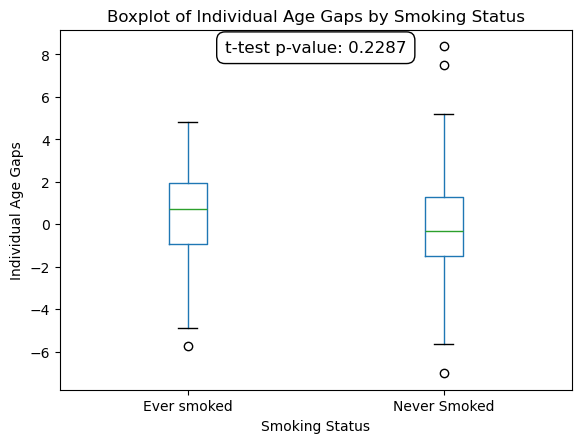

In [23]:
from scipy.stats import ttest_ind, shapiro, levene
from scipy.stats import mannwhitneyu

# Boxplot
plt.figure(figsize=(8, 6))
merged_df = pd.concat([test_corr_data['Individual age gaps'], smokers['Smoking Status']], axis=1)
merged_df.boxplot(column='Individual age gaps', by='Smoking Status', grid=False)

# Shapiro-Wilk test for normality
normality_results = {}
for category in merged_df['Smoking Status'].unique():
    data = merged_df['Individual age gaps'][merged_df['Smoking Status'] == category]
    _, p_value = shapiro(data)
    normality_results[category] = p_value

# Levene's test for equal variances
_, levene_p_value = levene(*[merged_df['Individual age gaps'][merged_df['Smoking Status'] == category] for category in merged_df['Smoking Status'].unique()])


# Check assumptions and perform t-tests
if all(p > 0.05 for p in normality_results.values()) and levene_p_value > 0.05:
    print('Assumptions are met and t-test is performed')
    data1 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[0]]
    data2 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[1]]
    t_statistic, p_value = ttest_ind(data1, data2, equal_var=True)
    plt.text(0.5, 0.95, f't-test p-value: {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    print(f"T-test between {merged_df['Smoking Status'].unique()[0]} and {merged_df['Smoking Status'].unique()[1]}: t-statistic={t_statistic:.4f}, p-value={p_value:.4f}")
else:
    print('Assumptions are not met, performing non-parametric test (Mann-Whitney U test)')
    data1 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[0]]
    data2 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[1]]
    _, p_value = mannwhitneyu(data1, data2)
    plt.text(0.5, 0.95, f'Mann-Whitney U test p-value: {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    print(f"Mann-Whitney U test between {merged_df['Smoking Status'].unique()[0]} and {merged_df['Smoking Status'].unique()[1]}: p-value={p_value:.4f}")


plt.title('Boxplot of Individual Age Gaps by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Individual Age Gaps')
plt.suptitle('')
plt.show()

## Biological clock - Idea 1

In [24]:
# Age (y-data)
R1_AgeID = R1_SOMAMeta[['visit_id', 'Age_years', 'Gender']]
R2_AgeID = R2_SOMAMeta[['visit_id', 'Age R2 (year)']]

# match R1 and R2 and rename
R1R2_AgeID = R1_AgeID.merge(R2_AgeID, on='visit_id').rename(columns={'Age_years': 'Age_R1', 'Age R2 (year)': 'Age_R2', 'Gender': 'Gender'})
R1R2_AgeID['Gender'] = R1R2_AgeID['Gender'].replace({"M": 0, "F": 1})

# calculate delta
age_delta = (R1R2_AgeID['Age_R2'] - R1R2_AgeID['Age_R1'])

# Protein (x-data)
shared_proteins = list(set(R1_SOMA.columns) & set(R2_SOMA.columns))
sel_col = ['visit_id'] + shared_proteins

R1_SOMAID = R1_SOMAMeta[sel_col]
R2_SOMAID = R2_SOMAMeta[sel_col]

# merge so the visit_ids match
R1R2_SOMAID = R1_SOMAID.merge(R2_SOMAID, on='visit_id')

delta_values = []

for protein in shared_proteins:
    col1 = R1R2_SOMAID[f'{protein}_x']
    col2 = R1R2_SOMAID[f'{protein}_y']
    delta_values.append(col2.values - col1.values)

SOMA_delta = pd.DataFrame(np.array(delta_values).T, columns=shared_proteins)

/tmp/ipykernel_3390037/20297152.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  R1R2_AgeID['Gender'] = R1R2_AgeID['Gender'].replace({"M": 0, "F": 1})


In [25]:
# Split train/test-data
X = SOMA_delta
y = age_delta
stratify = None

x_train_delta, x_test_delta, y_train_delta, y_test_delta = train_test_split(
    X, 
    y, 
    test_size = 0.2, 
    random_state = 42,
    stratify = stratify
)


sc = MinMaxScaler()
x_train_delta = sc.fit_transform(x_train_delta)
x_test_delta = sc.transform(x_test_delta)

#### Elastic net

In [26]:
%%script echo skip tuning
# Hyperparameter tuning
params = {
    'alpha':[0.003, 0.004, 0.005],  
    'l1_ratio': [0.4, 0.5, 0.6],
    'max_iter':[15000]
}
elnet_delta = GridSearchCV(ElasticNet(), params, n_jobs=35, scoring='neg_mean_squared_error', cv=5).fit(x_train_delta, y_train_delta)

print(elnet_delta.best_params_)

skip tuning


R-squared on traindata: 0.666152224913219
R-squared on testdata: 0.3455331644274596


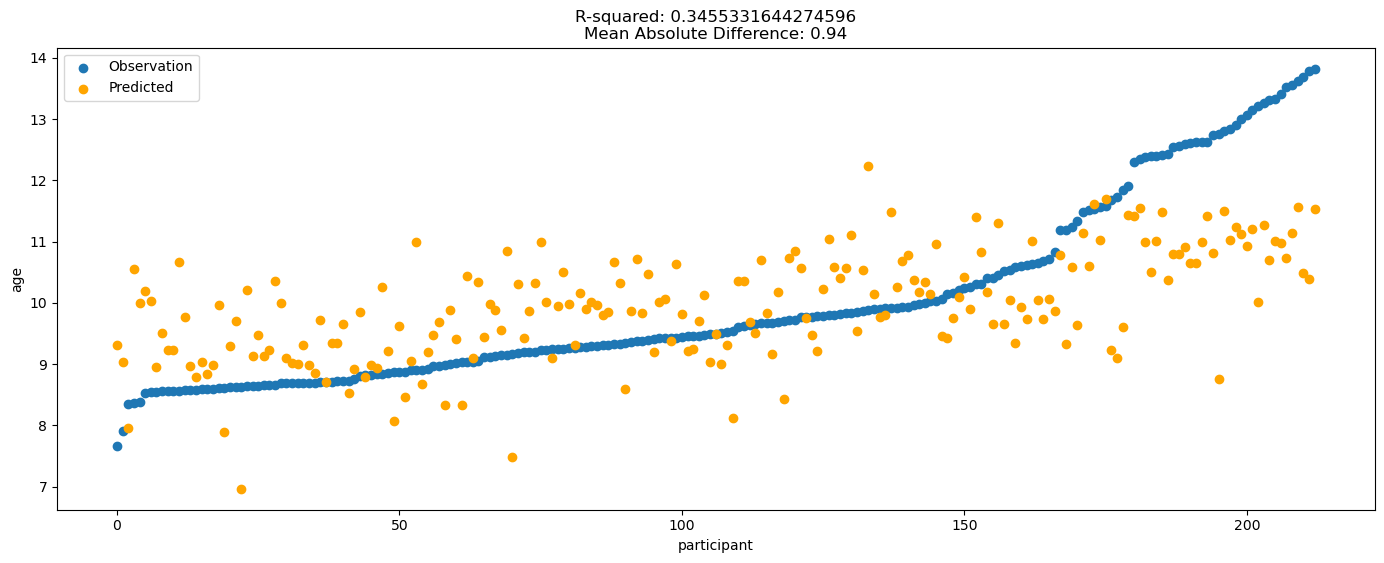

In [27]:
# Model using found hyperparameters
params = {'alpha': 0.005, 'l1_ratio': 0.4, 'max_iter': 15000}
model = ElasticNet(**params).fit(x_train_delta, y_train_delta)

# Apply the model
y_pred = model.predict(x_test_delta)
r2_train = r2_score(y_train_delta, model.predict(x_train_delta))
r2_test = r2_score(y_test_delta, y_pred)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_test_delta, y_pred)

#### Store the errors on the test data

In [28]:
test_ages = pd.DataFrame(age_delta.iloc[y_test_delta.index])
test_corr_data = pd.concat([test_ages.reset_index(drop=True), pd.DataFrame(y_pred).reset_index(drop=True)],
                       axis = 1, ignore_index=True)
test_corr_data.columns = ['Delta age', 'Predicted delta age']
test_corr_data['Error'] = test_corr_data['Predicted delta age'] - test_corr_data['Delta age']
print(np.mean(abs(test_corr_data['Error'])))

0.9389570550573759


#### Plot the errors in function of the true delta ages

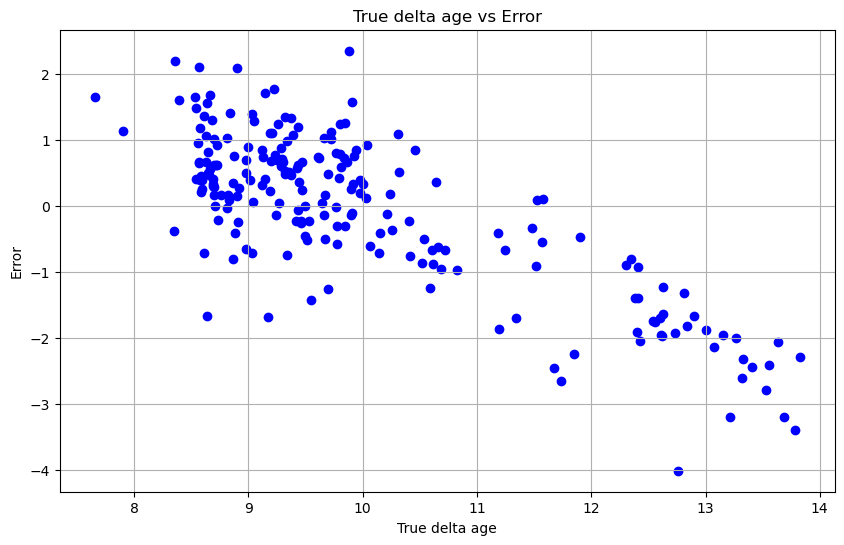

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(test_corr_data['Delta age'], test_corr_data['Error'], color='blue')

plt.title('True delta age vs Error')
plt.xlabel('True delta age')
plt.ylabel('Error')
plt.grid(True)
plt.show()

#### Fit a lowess on the delta ages vs the predicted delta ages and calculate age gaps (=difference between predicted value and lowess smoother)

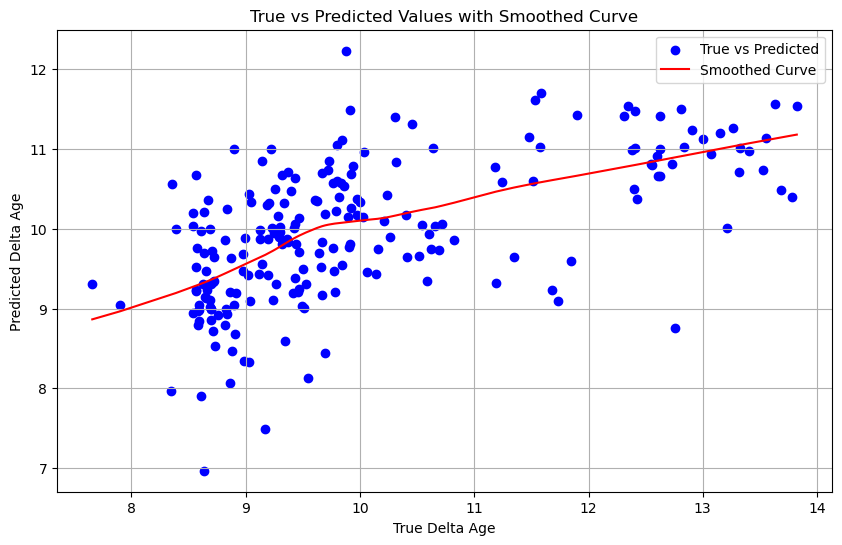

In [30]:
import statsmodels.api as sm

# Fit a local regression (LOESS)
lowess = sm.nonparametric.lowess
frac = 2/3  # Fraction parameter set to 2/3


test_corr_data_sorted = test_corr_data.sort_values(by='Delta age')

# Fit the lowess model
predicted_smooth = lowess(test_corr_data_sorted['Predicted delta age'], 
                          test_corr_data_sorted['Delta age'], 
                          frac=frac)

# Extracting smoothed values
smoothed_values = predicted_smooth[:, 1]

# Plotting true vs predicted values with smoothed curve and ElasticNet predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_corr_data['Delta age'], test_corr_data['Predicted delta age'], color='blue', label='True vs Predicted')
plt.plot(test_corr_data_sorted['Delta age'], smoothed_values, color='red', label='Smoothed Curve')

plt.title('True vs Predicted Values with Smoothed Curve')
plt.xlabel('True Delta Age')
plt.ylabel('Predicted Delta Age')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
individual_age_gaps = test_corr_data_sorted['Predicted delta age'] - smoothed_values

# Reindex individual_age_gaps to match the original index of test_corr_data
individual_age_gaps = individual_age_gaps.reindex(test_corr_data.index)

# Add individual age gaps to the DataFrame
test_corr_data['Individual age gaps'] = individual_age_gaps

# Print the DataFrame to verify
test_corr_data.head()

,Delta age,Predicted delta age,Error,Individual age gaps
0,10.212740,10.094835,-0.117905,-0.041594
1,9.802603,10.593110,0.790507,0.524190
2,8.593288,8.846876,0.253588,-0.454469
3,10.003699,10.336965,0.333267,0.235054
4,9.657260,9.516271,-0.140989,-0.510285


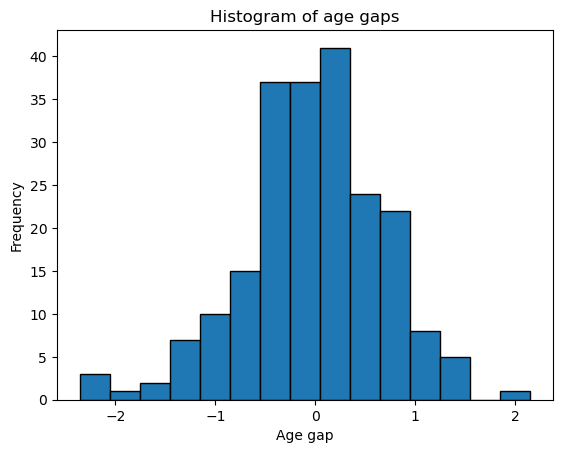

In [32]:
#histogram of the age gaps
plt.hist(test_corr_data['Individual age gaps'], bins=15, edgecolor='black')
plt.title('Histogram of age gaps')
plt.xlabel('Age gap')
plt.ylabel('Frequency')
plt.show()

#### Concatenate round 1 and round 2 metadata to do correlation analysis

In [33]:
all_metadata = pd.merge(R1_Metadata, R2_Metadata, on='visit_id')
print(all_metadata.shape)

(1064, 1677)


In [34]:
all(R1R2_AgeID['visit_id'] == all_metadata['visit_id'])

True

#### Correlation analysis of delta risk variables with age gaps

In [35]:
tmp_metadata = all_metadata.iloc[y_test_delta.index].reset_index()
metadata_delta = pd.DataFrame()
metadata_delta['Carotid IMT delta'] = tmp_metadata['Carotid IMT delta_R2']
metadata_delta['Femoral IMT delta'] = tmp_metadata['Femoral IMT delta_R2']
metadata_delta['BMI delta (kg/m²)'] = tmp_metadata['BMI delta (kg/m2)_R2']
metadata_delta['Systolic BP delta (mmHg)'] = tmp_metadata['Systolic BP delta (mmHg)_R2']
metadata_delta['Diastolic BP delta (mmHg)'] = tmp_metadata['Diastolic BP delta (mmHg)_R2']
metadata_delta['Pulse Pressure delta (mmHg)'] = tmp_metadata['Pulse Pressure delta (mmHg)_R2']
metadata_delta['Total cholesterol delta'] = tmp_metadata['Total cholesterol delta_R2']
metadata_delta['HDL cholesterol delta'] = tmp_metadata['HDL cholesterol delta_R2']
metadata_delta['LDL cholesterol delta'] = tmp_metadata['LDL cholesterol delta_R2']
metadata_delta['Triglycerides delta (mg/dl)'] = tmp_metadata['Triglycerides (mg/dl; R2)_R2'] - tmp_metadata['Triglycerides (mg/dl; R1)_R2']
metadata_delta['High sensitive CRP delta (mg/dL)'] = tmp_metadata['High sensitive CRP delta (mg/dL)_R2']
metadata_delta['IL6 delta'] = tmp_metadata['IL6 R2_R2'] - tmp_metadata['IL6 R1_R2']
metadata_delta['White blood cells delta'] = tmp_metadata['WBC R2_R2'] - tmp_metadata['Whitebloodcellcount10e3microl_R1']
metadata_delta['Fibrinogen delta'] = tmp_metadata['Fibrinogen R2_R2'] - tmp_metadata['Fibrinogen R1_R2']
metadata_delta['Homocystein delta'] = tmp_metadata['Homocystein R2_R2'] - tmp_metadata['Homocystein R1_R2']
metadata_delta['Glycemia delta'] = tmp_metadata['Glycemia delta_R2']
metadata_delta['Creatinin delta (mg/dl)'] = tmp_metadata['creat R2_R2'] - tmp_metadata['Creatinin_mgdl_R1']
metadata_delta['Uric acid delta (mg/dL)'] = tmp_metadata['Uric acid delta (mg/dL)_R2']
metadata_delta['Pack years nicotine delta (year)'] = tmp_metadata['Pack years nicotine delta (year)_R2']

In [36]:
from scipy.stats import pearsonr
from statsmodels.stats import multitest

colnames_new = []
p_vec = []
pval_vec = []
errors = test_corr_data['Individual age gaps']
errors.reset_index(drop=True, inplace=True)
test_metadata = metadata_delta

for i in np.arange(0, len(test_metadata.columns)):
    predictor = test_metadata.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    errors_filtered = errors[non_nan_idx]

    if len(errors_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(errors_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(test_metadata.columns[i])


corr_result = pd.DataFrame({'Predictor':colnames_new, 'Pearson Correlation':p_vec, 'P-value': pval_vec})
corr_result = corr_result.iloc[np.abs(corr_result['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

reject, corrected_pvals, _, _ = multitest.multipletests(corr_result['P-value'], method='fdr_bh')
corr_result['Corrected P-value'] = corrected_pvals
corr_result['Reject Null Hypothesis'] = reject

corr_result = corr_result.iloc[corr_result['Corrected P-value'].argsort()].reset_index(drop=True)

significant = corr_result[(corr_result['Reject Null Hypothesis'] == True)]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# significant.reset_index(drop=True)
corr_result

,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,High sensitive CRP delta (mg/dL),-0.104196,0.130468,0.628427,False
1,Carotid IMT delta,0.101917,0.138197,0.628427,False
2,White blood cells delta,-0.101880,0.138340,0.628427,False
3,LDL cholesterol delta,0.101136,0.148052,0.628427,False
4,Femoral IMT delta,0.095395,0.165376,0.628427,False
5,HDL cholesterol delta,-0.078622,0.253263,0.801998,False
6,Uric acid delta (mg/dL),0.068988,0.316288,0.858496,False
7,IL6 delta,-0.010911,0.877516,0.960980,False
8,Triglycerides delta (mg/dl),-0.011307,0.869694,0.960980,False
9,Fibrinogen delta,0.013787,0.841449,0.960980,False


#### Correlation analysis of average risk variables with age gaps

In [37]:
tmp_metadata = all_metadata.iloc[y_test_delta.index].reset_index()
metadata_average = pd.DataFrame()
metadata_average['Carotid IMT average'] = (tmp_metadata['Carotid IMT R2_R2'] + tmp_metadata['Carotid IMT R1_R2'])/2
metadata_average['Femoral IMT average'] = (tmp_metadata['Femoral IMT R2_R2'] + tmp_metadata['Femoral IMT R1_R2'])/2
metadata_average['BMI averaged (kg/m2)'] = tmp_metadata['BMI averaged (kg/m2)_R2']
metadata_average['Systolic BP average (mmHg)'] = tmp_metadata['Systolic BP averaged (mmHg)_R2']
metadata_average['Diastolic BP average (mmHg)'] = tmp_metadata['Diastolic BP averaged (mmHg)_R2']
metadata_average['Pulse Pressure average (mmHg)'] = tmp_metadata['Pulse pressure averaged (mmHg)_R2']
metadata_average['Total cholesterol average'] = tmp_metadata['Total cholesterol averaged_R2']
metadata_average['HDL cholesterol average'] = tmp_metadata['HDL cholesterol averaged_R2']
metadata_average['LDL cholesterol average'] = tmp_metadata['LDL cholesterol averaged_R2']
metadata_average['Triglycerides average (mg/dl)'] = (tmp_metadata['Triglycerides (mg/dl; R2)_R2'] + tmp_metadata['Triglycerides (mg/dl; R1)_R2'])/2
metadata_average['High sensitive CRP average (mg/dL)'] = tmp_metadata['High sensitive CRP averaged (mg/dL)_R2']
metadata_average['IL6 average'] = (tmp_metadata['IL6 R2_R2'] + tmp_metadata['IL6 R1_R2'])/2
metadata_average['White blood cells average'] = (tmp_metadata['WBC R2_R2'] + tmp_metadata['Whitebloodcellcount10e3microl_R1'])/2
metadata_average['Fibrinogen average'] = (tmp_metadata['Fibrinogen R2_R2'] + tmp_metadata['Fibrinogen R1_R2'])/2
metadata_average['Homocystein average'] = (tmp_metadata['Homocystein R2_R2'] + tmp_metadata['Homocystein R1_R2'])/2
metadata_average['Glycemia average'] = tmp_metadata['Glycemia averaged_R2']
metadata_average['Creatinin average (mg/dl)'] = (tmp_metadata['creat R2_R2'] + tmp_metadata['Creatinin_mgdl_R1'])/2
metadata_average['Uric acid average (mg/dL)'] = tmp_metadata['Uric acid averaged (mg/dL)_R2']
metadata_average['Pack years nicotine average (year)'] = (tmp_metadata['Pack years nicotine R1 (year)_R2'] + tmp_metadata['Pack years nicotine R2 (year)_R2'])/2

In [38]:
from scipy.stats import pearsonr
from statsmodels.stats import multitest

colnames_new = []
p_vec = []
pval_vec = []
errors = test_corr_data['Individual age gaps']
errors.reset_index(drop=True, inplace=True)
test_metadata = metadata_average

for i in np.arange(0, len(test_metadata.columns)):
    predictor = test_metadata.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    errors_filtered = errors[non_nan_idx]

    if len(errors_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(errors_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(test_metadata.columns[i])


corr_result = pd.DataFrame({'Predictor':colnames_new, 'Pearson Correlation':p_vec, 'P-value': pval_vec})
corr_result = corr_result.iloc[np.abs(corr_result['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

reject, corrected_pvals, _, _ = multitest.multipletests(corr_result['P-value'], method='fdr_bh')
corr_result['Corrected P-value'] = corrected_pvals
corr_result['Reject Null Hypothesis'] = reject

corr_result = corr_result.iloc[corr_result['Corrected P-value'].argsort()].reset_index(drop=True)
# outputting the 10 highest correlated predictors:
significant = corr_result[(corr_result['Reject Null Hypothesis'] == True)]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# significant.reset_index(drop=True)
corr_result

,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,High sensitive CRP average (mg/dL),0.224775,0.000982,0.018654,True
1,Creatinin average (mg/dl),-0.134205,0.050467,0.399689,False
2,Fibrinogen average,0.114287,0.096192,0.399689,False
3,LDL cholesterol average,-0.107812,0.122957,0.399689,False
4,Pulse Pressure average (mmHg),0.106708,0.120513,0.399689,False
5,Homocystein average,-0.101584,0.139497,0.399689,False
6,Femoral IMT average,-0.099234,0.166418,0.399689,False
7,Total cholesterol average,-0.094745,0.168290,0.399689,False
8,Carotid IMT average,-0.055954,0.416536,0.719471,False
9,Diastolic BP average (mmHg),-0.056202,0.414468,0.719471,False


In [39]:
# Define a function to determine smoking status based on the two rounds
def smoking_status(round1, round2):
    if round1 == 'yes' or round2 == 'yes':
        return 'Ever smoked'
    elif round1 == 'no' and round2 == 'no':
        return 'Never Smoked'

# Create a list of tuples containing the combinations of smoker status for each individual
data = [(round1, round2, smoking_status(round1, round2)) for round1, round2 in zip(tmp_metadata['Current Smoker R1_R2'], tmp_metadata['Current Smoker R2_R2'])]

# Create a new DataFrame from the list of tuples
smokers = pd.DataFrame(data, columns=['Smoker Round 1', 'Smoker Round 2', 'Smoking Status'])

Assumptions are not met, performing non-parametric test (Mann-Whitney U test)
Mann-Whitney U test between Never Smoked and Ever smoked: p-value=0.6758


<Figure size 800x600 with 0 Axes>

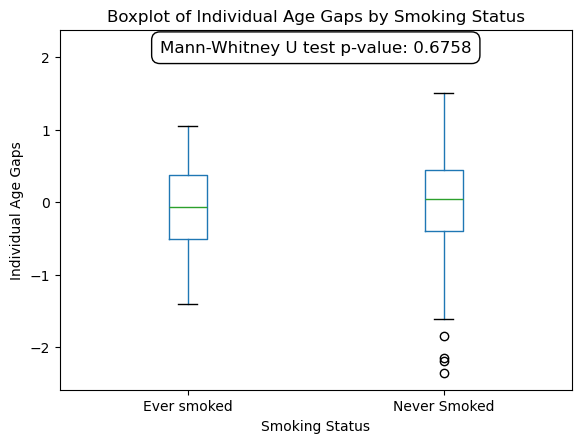

In [40]:
from scipy.stats import ttest_ind, shapiro, levene
from scipy.stats import mannwhitneyu

# Boxplot
plt.figure(figsize=(8, 6))
merged_df = pd.concat([test_corr_data['Individual age gaps'], smokers['Smoking Status']], axis=1)
merged_df.boxplot(column='Individual age gaps', by='Smoking Status', grid=False)

# Shapiro-Wilk test for normality
normality_results = {}
for category in merged_df['Smoking Status'].unique():
    data = merged_df['Individual age gaps'][merged_df['Smoking Status'] == category]
    _, p_value = shapiro(data)
    normality_results[category] = p_value

# Levene's test for equal variances
_, levene_p_value = levene(*[merged_df['Individual age gaps'][merged_df['Smoking Status'] == category] for category in merged_df['Smoking Status'].unique()])


# Check assumptions and perform t-tests
if all(p > 0.05 for p in normality_results.values()) and levene_p_value > 0.05:
    print('Assumptions are met and t-test is performed')
    data1 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[0]]
    data2 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[1]]
    t_statistic, p_value = ttest_ind(data1, data2, equal_var=True)
    plt.text(0.5, 0.95, f't-test p-value: {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    print(f"T-test between {merged_df['Smoking Status'].unique()[0]} and {merged_df['Smoking Status'].unique()[1]}: t-statistic={t_statistic:.4f}, p-value={p_value:.4f}")
else:
    print('Assumptions are not met, performing non-parametric test (Mann-Whitney U test)')
    data1 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[0]]
    data2 = merged_df['Individual age gaps'][merged_df['Smoking Status'] == merged_df['Smoking Status'].unique()[1]]
    _, p_value = mannwhitneyu(data1, data2)
    plt.text(0.5, 0.95, f'Mann-Whitney U test p-value: {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    print(f"Mann-Whitney U test between {merged_df['Smoking Status'].unique()[0]} and {merged_df['Smoking Status'].unique()[1]}: p-value={p_value:.4f}")


plt.title('Boxplot of Individual Age Gaps by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Individual Age Gaps')
plt.suptitle('')
plt.show()

## Mixed Model

#### Randomly select phase to include in the trainingset (resp. testset)

In [41]:
# Age (y-data)
R1_AgeID = R1_SOMAMeta[['visit_id', 'Age_years']]
R2_AgeID = R2_SOMAMeta[['visit_id', 'Age R2 (year)']]

# match R1 and R2 and rename
R1R2_AgeID = R1_AgeID.merge(R2_AgeID, on='visit_id').rename(columns={'Age_years': 'Age_x', 'Age R2 (year)': 'Age_y'})


# Protein (x-data)
shared_proteins = list(set(R1_SOMA.columns) & set(R2_SOMA.columns))
sel_col = ['visit_id'] + shared_proteins

R1_SOMAID = R1_SOMAMeta[sel_col]
R2_SOMAID = R2_SOMAMeta[sel_col]

# merge so the visit_ids match
R1R2_SOMAID = R1_SOMAID.merge(R2_SOMAID, on='visit_id')

In [42]:
np.random.seed(40)
# Add age data
matched_data = R1R2_SOMAID.merge(R1R2_AgeID, on='visit_id')

# Dictionary for splitting data
option_dict = {'xy':['_x','_y'], 'yx':['_y','_x']}
round_dict = {'_x': 1, '_y': 2}
# Split train/test-data
train = []
test = []
chosen_rounds = []
n_samples = len(matched_data)
for i in range(n_samples):
    chosen_round = option_dict[np.random.choice(['xy', 'yx'])]
    
    train_round_identifier = chosen_round[0]
    test_round_identifier = chosen_round[1]
    
    chosen_rounds.append(round_dict[test_round_identifier])

    train_columns = matched_data.columns.str.endswith(train_round_identifier)
    test_columns = matched_data.columns.str.endswith(test_round_identifier)

    train.append(matched_data.loc[i, train_columns].reset_index(drop=True))
    test.append(matched_data.loc[i, test_columns].reset_index(drop=True))

In [43]:
# Make column names list
columns = shared_proteins + ['Age']

# Make dataframes
train_df = pd.DataFrame(train)
train_df.columns = columns

test_df = pd.DataFrame(test)
test_df.columns = columns

# Separate x and y
x_mix_train = train_df.drop('Age', axis=1)
y_mix_train = train_df['Age']

x_mix_test = test_df.drop('Age', axis=1)
y_mix_test = test_df['Age']

# Scale data
mixed_model_scaler = MinMaxScaler()
x_mix_train_scaled = mixed_model_scaler.fit_transform(x_mix_train)
x_mix_test_scaled = mixed_model_scaler.transform(x_mix_test)

#### Elastic net

In [44]:
%%script echo skip tuning
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.005, 0.0075],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9],
    'max_iter': [15000],
}

# param_grid = {
#     'alpha': [0.0075],
#     'l1_ratio': [0.5],
#     'max_iter': [5000],
# }

# Run hyperparameter search
dataloader = {
    'x_train': x_mix_train_scaled,
    'y_train': y_mix_train,
    'x_test': x_mix_test_scaled,
    'y_test': y_mix_test
}

results, best_model, predictions_mixed = hyperparameter_search_EN(dataloader, param_grid, results, clock_name='mixed', cores=35)

validation_plot(y_mix_test, predictions_mixed)

skip tuning


R-squared on traindata: 0.9118475704126044
R-squared on testdata: 0.6076496363886563


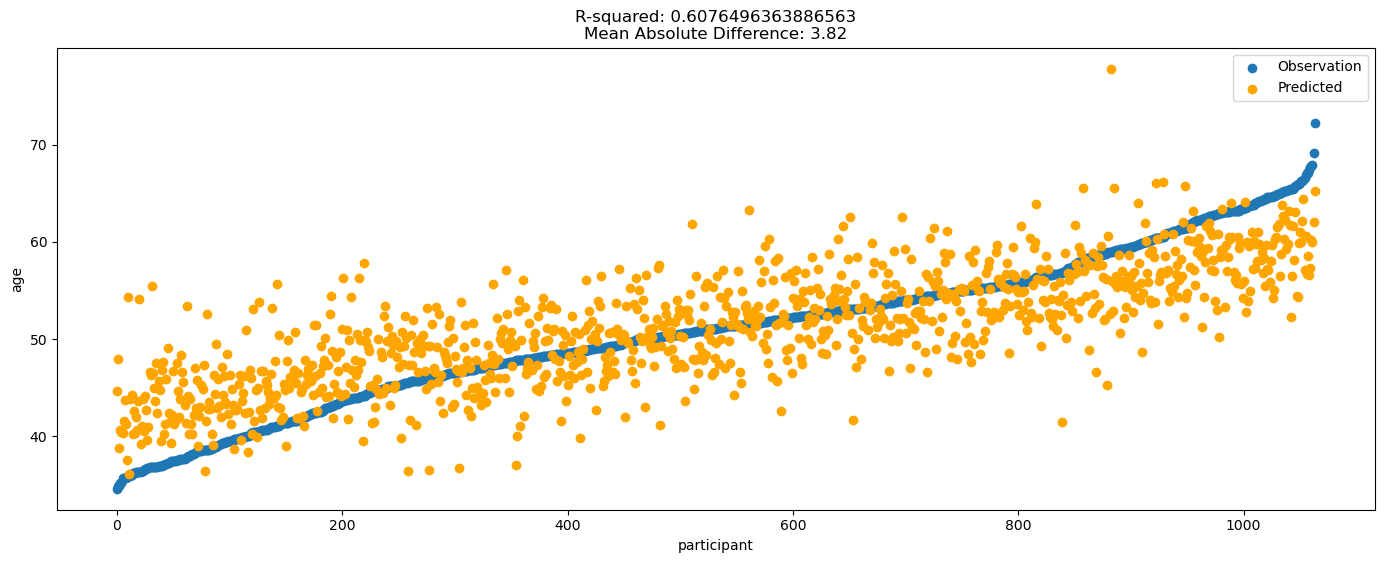

In [45]:
# Model using found hyperparameters
params = {'alpha': 0.0075, 'l1_ratio': 0.5, 'max_iter': 15000}
model = ElasticNet(**params).fit(x_mix_train_scaled, y_mix_train)


# Apply the model
y_pred = model.predict(x_mix_test_scaled)
r2_train = r2_score(y_mix_train, model.predict(x_mix_train_scaled))
r2_test = r2_score(y_mix_test, y_pred)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_mix_test, y_pred)

#### Store the errors on the test data

In [46]:
test_ages = pd.DataFrame(y_mix_test)
test_corr_data = pd.concat([test_ages.reset_index(drop=True), pd.DataFrame(y_pred).reset_index(drop=True)],
                       axis = 1, ignore_index=True)
test_corr_data.columns = ['Age', 'Predicted age']
test_corr_data['Error'] = test_corr_data['Predicted age'] - test_corr_data['Age']
print(np.mean(abs(test_corr_data['Error'])))

3.8238573258621145


#### Plot the errors in function of the true ages

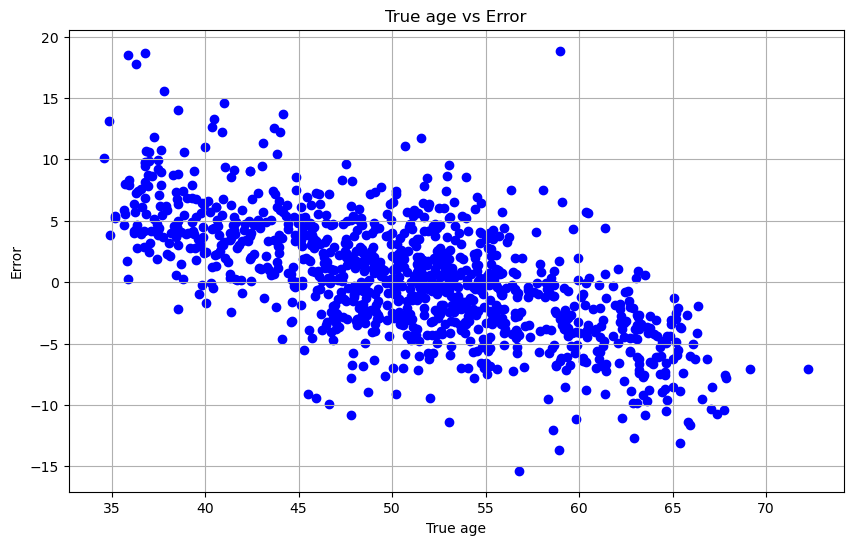

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(test_corr_data['Age'], test_corr_data['Error'], color='blue')

plt.title('True age vs Error')
plt.xlabel('True age')
plt.ylabel('Error')
plt.grid(True)
plt.show()

#### Fit a lowess on the true ages vs the predicted ages and calculate age gaps (=difference between predicted value and lowess smoother)

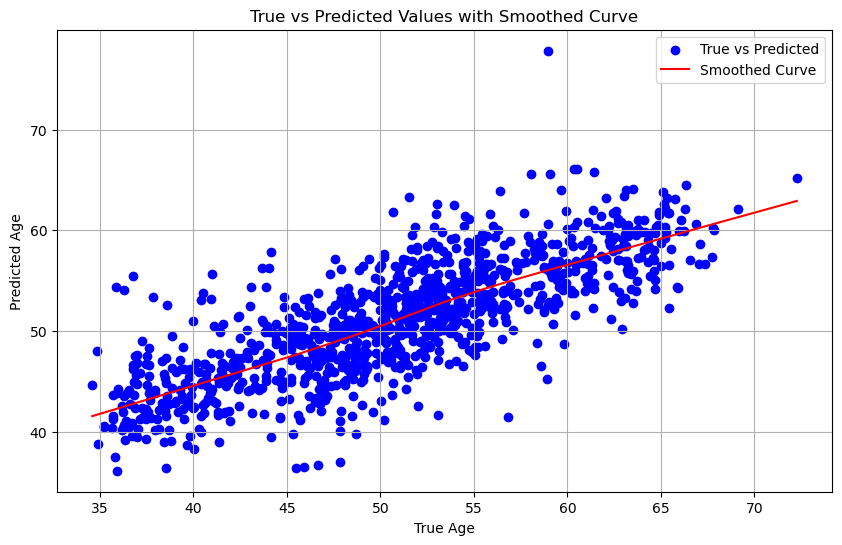

In [48]:
import statsmodels.api as sm

# Fit a local regression (LOESS)
lowess = sm.nonparametric.lowess
frac = 2/3  # Fraction parameter set to 2/3


test_corr_data_sorted = test_corr_data.sort_values(by='Age')

# Fit the lowess model
predicted_smooth = lowess(test_corr_data_sorted['Predicted age'], 
                          test_corr_data_sorted['Age'], 
                          frac=frac)

# Extracting smoothed values
smoothed_values = predicted_smooth[:, 1]

# Plotting true vs predicted values with smoothed curve and ElasticNet predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_corr_data['Age'], test_corr_data['Predicted age'], color='blue', label='True vs Predicted')
plt.plot(test_corr_data_sorted['Age'], smoothed_values, color='red', label='Smoothed Curve')

plt.title('True vs Predicted Values with Smoothed Curve')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
individual_age_gaps = test_corr_data_sorted['Predicted age'] - smoothed_values

# Reindex individual_age_gaps to match the original index of test_corr_data
individual_age_gaps = individual_age_gaps.reindex(test_corr_data.index)

# Add individual age gaps to the DataFrame
test_corr_data['Individual age gaps'] = individual_age_gaps

# Print the DataFrame to verify
test_corr_data.head()

,Age,Predicted age,Error,Individual age gaps
0,66.860274,60.613845,-6.246429,0.482879
1,54.720000,54.093132,-0.626868,0.398168
2,51.920000,56.121056,4.201056,4.273138
3,43.650000,51.060930,7.410930,4.463439
4,62.920548,50.197882,-12.722666,-7.883508


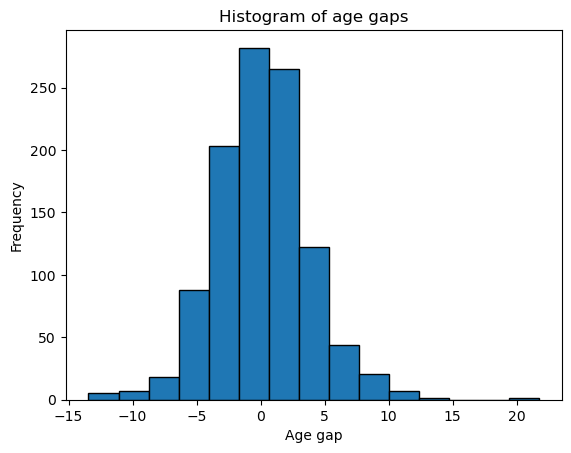

In [50]:
#histogram of age gaps
plt.hist(test_corr_data['Individual age gaps'], bins=15, edgecolor='black')
plt.title('Histogram of age gaps')
plt.xlabel('Age gap')
plt.ylabel('Frequency')
plt.show()

#### Concatenate round 1 and round 2 metadata to do correlation analysis

In [51]:
all_metadata = pd.merge(R1_Metadata, R2_Metadata, on='visit_id')
print(all_metadata.shape)

(1064, 1677)


In [52]:
all(R1R2_AgeID['visit_id'] == all_metadata['visit_id'])

True

#### Correlation analysis of risk variables with age gaps

In [53]:
metadata_individuals = pd.DataFrame(columns=['Carotid IMT', 'Femoral IMT', 'BMI (kg/m²)', 'Systolic BP (mmHg)', 'Diastolic BP (mmHg)',
                                             'Pulse Pressure (mmHg)', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol',
                                             'Triglycerides (mg/dl)', 'High sensitive CRP (mg/dL)', 'IL6', 'White blood cells', 'Fibrinogen',
                                             'Homocystein', 'Glycemia', 'Creatinin (mg/dl)', 'Uric acid (mg/dL)', 'Pack years nicotine (year)', 'Smoker'])

columns_r1 = ['Carotid IMT R1_R2', 'Femoral IMT R1_R2', 'BMI R1 (kg/m2)_R2', 'Systolic BP R1 (mmhg)_R2', 'Diastolic BP R1 (mmHg)_R2',
                                             'Pulse Pressure R1 (mmHg)_R2', 'Total cholesterol R1_R2', 'HDL cholesterol R1_R2', 'LDL cholesterol R1_R2',
                                             'Triglycerides (mg/dl; R1)_R2', 'High sensitive CRP R1 (mg/dL)_R2', 'IL6 R1_R2', 'Whitebloodcellcount10e3microl_R1', 
                                             'Fibrinogen R1_R2', 'Homocystein R1_R2', 'Glycemia R1_R2', 'Creatinin_mgdl_R1', 'Uric acid R1 (mg/dL)_R2',
                                             'Pack years nicotine R1 (year)_R2', 'Current Smoker R1_R2']

columns_r2 = ['Carotid IMT R2_R2', 'Femoral IMT R2_R2', 'BMI R2 (kg/m2)_R2', 'Systolic BP R2 (mmHg)_R2', 'Diastolic BP R2 (mmHg)_R2',
                                             'Pulse Pressure R2 (mmHg)_R2', 'Total cholesterol R2_R2', 'HDL cholesterol R2_R2', 'LDL cholesterol R2_R2',
                                             'Triglycerides (mg/dl; R2)_R2', 'High sensitive CRP R2 (mg/dL)_R2', 'IL6 R2_R2', 'WBC R2_R2', 
                                             'Fibrinogen R2_R2', 'Homocystein R2_R2', 'Glycemia R2_R2', 'creat R2_R2', 'Uric acid R2 (mg/dL)_R2',
                                             'Pack years nicotine R2 (year)_R2', 'Current Smoker R2_R2']

for i in range(len(matched_data)):
    chosen_round = chosen_rounds[i]
    if chosen_round == 1:
        metadata_individuals.loc[i] = all_metadata.iloc[i][columns_r1].values
    else:
        metadata_individuals.loc[i] = all_metadata.iloc[i][columns_r2].values

In [54]:
print(metadata_individuals.shape)

(1064, 20)


In [55]:
from scipy.stats import pearsonr
from statsmodels.stats import multitest

colnames_new = []
p_vec = []
pval_vec = []
errors = test_corr_data['Individual age gaps']
errors.reset_index(drop=True, inplace=True)
test_metadata = metadata_individuals

for i in np.arange(0, len(test_metadata.columns)):
    predictor = test_metadata.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    errors_filtered = errors[non_nan_idx]

    if len(errors_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(errors_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(test_metadata.columns[i])


corr_result = pd.DataFrame({'Predictor':colnames_new, 'Pearson Correlation':p_vec, 'P-value': pval_vec})
corr_result = corr_result.iloc[np.abs(corr_result['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

reject, corrected_pvals, _, _ = multitest.multipletests(corr_result['P-value'], method='fdr_bh')
corr_result['Corrected P-value'] = corrected_pvals
corr_result['Reject Null Hypothesis'] = reject

corr_result = corr_result.iloc[corr_result['Corrected P-value'].argsort()].reset_index(drop=True)

significant = corr_result[(corr_result['Reject Null Hypothesis'] == True)]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# significant.reset_index(drop=True)
corr_result

,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,Total cholesterol,0.094380,0.002057,0.035310,True
1,HDL cholesterol,0.086947,0.004537,0.035310,True
2,Fibrinogen,0.084920,0.005575,0.035310,True
3,LDL cholesterol,0.078645,0.010718,0.042828,True
4,Homocystein,0.076652,0.012383,0.042828,True
5,Uric acid (mg/dL),0.074060,0.015682,0.042828,True
6,Diastolic BP (mmHg),0.074026,0.015779,0.042828,True
7,BMI (kg/m²),0.064809,0.034536,0.082024,False
8,Systolic BP (mmHg),0.060141,0.049961,0.105473,False
9,Triglycerides (mg/dl),-0.047575,0.120928,0.229764,False


In [56]:
smokers = metadata_individuals['Smoker']

Mann-Whitney U test between no and yes: p-value=0.2372


/opt/mambaforge/envs/designproject_2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/mambaforge/envs/designproject_2023/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 800x600 with 0 Axes>

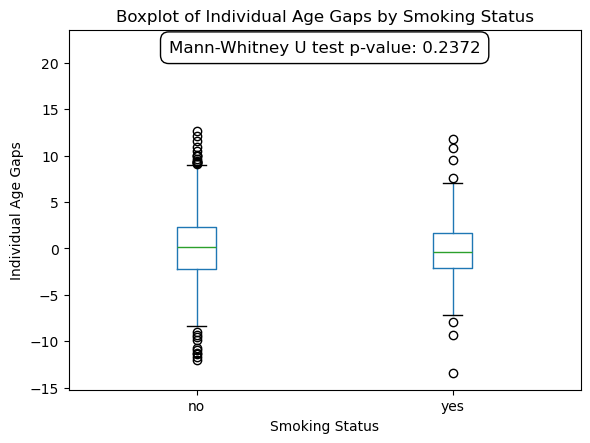

In [80]:
from scipy.stats import ttest_ind, shapiro, levene
from scipy.stats import mannwhitneyu

# Boxplot
plt.figure(figsize=(8, 6))
merged_df = pd.concat([test_corr_data['Individual age gaps'], smokers], axis=1)
merged_df.boxplot(column='Individual age gaps', by='Smoker', grid=False)

# Shapiro-Wilk test for normality
normality_results = {}
for category in merged_df['Smoker'].unique()[0:2]:
    data = merged_df['Individual age gaps'][merged_df['Smoker'] == category]
    _, p_value = shapiro(data)
    normality_results[category] = p_value

# Levene's test for equal variances
_, levene_p_value = levene(*[merged_df['Individual age gaps'][merged_df['Smoker'] == category] for category in merged_df['Smoker'].unique()])


# Check assumptions and perform t-tests
if all(p > 0.05 for p in normality_results.values()) and levene_p_value > 0.05:
    print('Assumptions are met and t-test is performed')
    data1 = merged_df['Individual age gaps'][merged_df['Smoker'] == merged_df['Smoker'].unique()[0]]
    data2 = merged_df['Individual age gaps'][merged_df['Smoker'] == merged_df['Smoker'].unique()[1]]
    t_statistic, p_value = ttest_ind(data1, data2, equal_var=True)
    plt.text(0.5, 0.95, f't-test p-value: {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    print(f"T-test between {merged_df['Smoker'].unique()[0]} and {merged_df['Smoker'].unique()[1]}: t-statistic={t_statistic:.4f}, p-value={p_value:.4f}")
else:
    # Get unique smoking status categories
    categories = merged_df['Smoker'].unique()

    # Check if any group is empty
    if any(merged_df['Smoker'].value_counts() == 0):
        print("Error: One or both groups are empty.")
    else:
        # Perform Mann-Whitney U test
        _, p_value = mannwhitneyu(data1, data2)
        plt.text(0.5, 0.95, f'Mann-Whitney U test p-value: {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        print(f"Mann-Whitney U test between {categories[0]} and {categories[1]}: p-value={p_value:.4f}")



plt.title('Boxplot of Individual Age Gaps by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Individual Age Gaps')
plt.suptitle('')
plt.show()

## Mixed Model No Overlap Train Test

#### Randomly select phase to include in the trainingset (resp. testset)

In [81]:
# Round 1
R1_SOMAMeta_raw = pd.read_csv(R1_path, low_memory=False)
R1_SOMAMeta_raw['VisitB_Date'] = pd.to_datetime(R1_SOMAMeta_raw['VisitB_Date'])
R1_SOMAMeta_raw['year-month'] = R1_SOMAMeta_raw['VisitB_Date'].dt.strftime('%Y-%m')

# Remove batch effected months April, May, June, July (2003)
months_to_remove = [4, 5, 6, 7] 
R1_SOMAMeta = R1_SOMAMeta_raw.copy()
R1_SOMAMeta = R1_SOMAMeta[~((R1_SOMAMeta['VisitB_Date'].dt.year == 2003) & 
                            (R1_SOMAMeta['VisitB_Date'].dt.month.isin(months_to_remove)))]
R1_SOMAMeta['year-month'] = R1_SOMAMeta['VisitB_Date'].dt.strftime('%Y-%m')


# Round 2
R2_SOMAMeta = pd.read_csv(R2_path, low_memory=False)

R2_SOMAMeta['Examination date R2'] = pd.to_datetime(R2_SOMAMeta['Examination date R2'])
R2_SOMAMeta['year-month'] = R2_SOMAMeta['Examination date R2'].dt.strftime('%Y-%m')

# Set Index
R1_SOMAMeta = R1_SOMAMeta.set_index(R1_SOMAMeta['visit_id'])
R2_SOMAMeta = R2_SOMAMeta.set_index(R2_SOMAMeta['visit_id'])

# Select proteins
R1_SOMA = R1_SOMAMeta.loc[:, R1_SOMAMeta.columns.str.startswith('seq')]
R2_SOMA = R2_SOMAMeta.loc[:, R2_SOMAMeta.columns.str.startswith('seq')]

 # there is one protein in R2 that is not in R1 (seq.20367.6)
shared_proteins = list(set(R1_SOMA.columns) & set(R2_SOMA.columns)) 
R1_SOMA = R1_SOMA.loc[:, shared_proteins]
R2_SOMA = R2_SOMA.loc[:, shared_proteins]


# Select metadata
R1_Meta = R1_SOMAMeta.loc[:, ~R1_SOMAMeta.columns.str.startswith('seq')]
R2_Meta = R2_SOMAMeta.loc[:, ~R2_SOMAMeta.columns.str.startswith('seq')]


# TargetID to EntrezID
analyte = pd.read_csv(probe_path)
analyte_conv = analyte[['SeqIndex', 'EntrezGeneSymbol']]

In [90]:
# Age (y-data)
R1_AgeID = R1_SOMAMeta['Age_years'].to_frame().rename(columns={'Age_years': 'Age'})
R2_AgeID = R2_SOMAMeta['Age R2 (year)'].to_frame().rename(columns={'Age R2 (year)': 'Age'})

# match R1 and R2 on index and rename
R1R2_AgeID = R1_AgeID.merge(R2_AgeID, left_index=True, right_index=True ).rename(columns={'Age_years': 'Age_R1', 'Age R2 (year)': 'Age_R2'})

# Protein (x-data)
shared_proteins = list(set(R1_SOMA.columns) & set(R2_SOMA.columns))
sel_col = shared_proteins

R1_SOMAID = R1_SOMAMeta[sel_col]
R2_SOMAID = R2_SOMAMeta[sel_col]

R1R2_SOMAID = R1_SOMAID.merge(R2_SOMAID, left_index=True, right_index=True )

In [101]:
# sample without replacement
np.random.seed(40)
sample_index = np.random.choice(R1R2_AgeID.index, size=int(0.8*len(R1R2_SOMAID)//1), replace=False)

# R1_SOMA = R1_SOMA.set_index('visit_id')
# R2_SOMA = R2_SOMA.set_index('visit_id')

X_train_R1 = R1_SOMA.loc[sample_index]
X_train_R2 = R2_SOMA.loc[sample_index]
y_train_R1 = R1_AgeID.loc[sample_index]
y_train_R2 = R2_AgeID.loc[sample_index]


X_test_R1 = R1_SOMA.drop(sample_index)
X_test_R2 = R2_SOMA.drop(sample_index)
y_test_R1 = R1_AgeID.drop(sample_index)
y_test_R2 = R2_AgeID.drop(sample_index)

In [102]:
# Concat R1 and R2
X_train = pd.concat([X_train_R1, X_train_R2], axis=0)
X_test = pd.concat([X_test_R1, X_test_R2], axis=0)

y_train = pd.concat([y_train_R1, y_train_R2], axis=0)
y_test = pd.concat([y_test_R1, y_test_R2], axis=0)

smarter_scale = MinMaxScaler()
X_train = smarter_scale.fit_transform(X_train)
X_test = smarter_scale.transform(X_test)

#### Elastic net

In [ ]:
# %%script echo skip tuning
# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'alpha': [0.002, 0.005, 0.0075],
#     'l1_ratio': [0.1, 0.5, 0.9],
#     'max_iter': [5000],
# }

param_grid = {
    'alpha': [0.01, 0.015, 0.02],
    'l1_ratio': [0.1, 0.5, 0.9],
    'max_iter': [5000],
}

# Run hyperparameter search
dataloader = {
    'x_train': X_train,
    'y_train': y_train,
    'x_test': X_test,
    'y_test': y_test
}

results, best_model, predictions_smort = hyperparameter_search_EN(dataloader, param_grid, results, clock_name='smort', cores = 35)

validation_plot(y_test['Age'], predictions_smort)

R-squared on traindata: 0.7774890338660685
R-squared on testdata: 0.5662850589494284


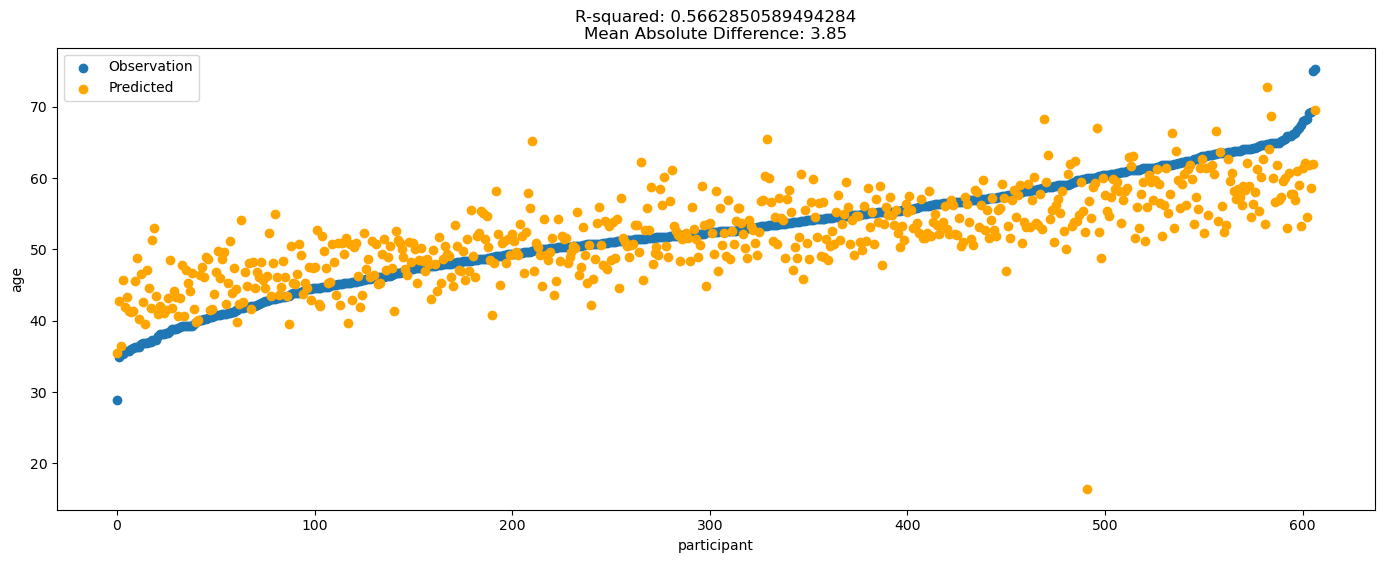

In [113]:
# Model using found hyperparameters
params = {'alpha': 0.012, 'l1_ratio': 0.9, 'max_iter': 15000}
model = ElasticNet(**params).fit(X_train, y_train)


# Apply the model
y_pred = model.predict(X_test)
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, y_pred)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_test['Age'], y_pred)